In [14]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

import requests
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

In [17]:
llm = ChatOpenAI(
    api_key="ollama",
    model="llama3.3",
    base_url="http://localhost:11434/v1",
)

def navigate(origin: str, destination: str) -> str:
    """Check if there is a path between origin and destination addresses.
    
    Args:
        origin: starting address
        destination: ending address
    """
    
    response = requests.post(
        'http://localhost:5000/api/navigate',
        json={'origin': origin, 'destination': destination}
    )
    return response.json()['message']

llama_tools = llm.bind_tools([navigate])


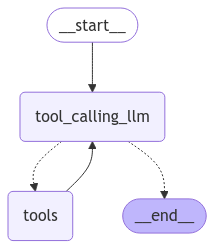

In [26]:
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llama_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([navigate]))

builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tools", "tool_calling_llm")
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
messages = graph.invoke({"messages": HumanMessage(content="Can i go from 123 pine rd to 456 oak ave? If that doesn't work, can i go from 123 main st to 789 pine rd?")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Can i go from 123 pine rd to 456 oak ave? If that doesn't work, can i go from 123 main st to 789 pine rd?
================================== Ai Message ==================================
Tool Calls:
  navigate (call_xzoz3f54)
 Call ID: call_xzoz3f54
  Args:
    destination: 456 oak ave
    origin: 123 pine rd
  navigate (call_lv9k63vc)
 Call ID: call_lv9k63vc
  Args:
    destination: 789 pine rd
    origin: 123 main st
================================= Tool Message =================================
Name: navigate

Invalid origin address: 123 pine rd
================================= Tool Message =================================
Name: navigate

There is a path between origin and destination
================================== Ai Message ==================================

You can go from 123 Main St to 789 Pine Rd. Unfortunately, I was unable to verify the route from 123 Pine Rd to 456 Oak Ave as the origi